In [2]:
import os
import sys
import numpy as np
import pandas as pd
import json

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

import seaborn as sns

In [3]:
module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from global_config import ROOT_DIR, AU_INTENSITY_COLS, GAZE_COLS, POSE_COLS, \
    AUDIO_FUNCTIONALS_EGEMAPS_COLS, emotion_abr_to_emotion
from src.analysis.supervised_learning.evaluation.confusion_matrix import ConfusionMatrixCreator, conf_mat_to_df, \
    plot_conf_matrix


from src.preprocessing.dataset_creation.scaling.functional_scaling import functional_scale_by
from src.preprocessing.dataset_creation.scaling.low_level_scaling import low_level_scale_by


from src.preprocessing.dataset_creation.helpers import slice_by, get_cols, get_fixed_col
from src.preprocessing.dataset_creation.aggregation import get_aggregate_measures
from src.preprocessing.dataset_creation.interpolation import Interpolator
from src.preprocessing.dataset_creation.fusion import align_audio_video

In [5]:
def param_search(x, y):
    # regularization parameter, lower C -> more regularization,
    # large C -> less regularization
    c_values = [0.1, 1, 5, 10, 25, 50, 75, 100]

    gamma = [1, 0.1, 0.01, 0.001, 0.0001]

    kernel = ['rbf', 'linear', 'poly', 'sigmoid']

    parameters = {'class_weight': ['balanced'],
                  'C': c_values,
                  'gamma': gamma,
                  'kernel': kernel,
                  }


    skf = StratifiedKFold(n_splits=5, shuffle=True)

    svc = SVC()
    clf = GridSearchCV(estimator=svc,
                       param_grid=parameters,
                       scoring='accuracy',
                       verbose=5,
                       cv=skf.split(x, y),
                       n_jobs=-1,
                       )

    clf.fit(x, y)
    print(clf.best_params_)
    return clf

In [6]:
def check_alignment(sli, df):
    y_sli = get_fixed_col(sli, "emotion_1_id")
    y_df = df["emotion_1_id"].values
    print(np.array_equal(y_sli, y_df))

    y_sli = get_fixed_col(sli, "video_id")
    y_df = df["video_id"].values
    print(np.array_equal(y_sli, y_df))

In [7]:
def transform_video_modality(sli, cols):
    x = get_cols(sli, cols)
    x = low_level_scale_by(slices=x,
                           by=video_ids,
                           method="standard")

    x_agg = get_aggregate_measures(x)
    scaler = MinMaxScaler()
    return scaler.fit_transform(x_agg)

In [8]:
class Evaluator:
    conf_mat_save_path = os.path.join(ROOT_DIR,
                                      "files/out/functionals/supervised_learning/confusion_matrix_")
    classification_report_save_path = os.path.join(ROOT_DIR,
                                      "files/out/functionals/supervised_learning/classification_report_")

    def __init__(self, x, y, model_parameters, save_as):
        self.x = x
        self.y = y
        self.clf = SVC(**model_parameters, probability=True)
        self.save_as = save_as

    def get_splits(self):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
        return skf.split(self.x, self.y)

    def evaluate_scores(self, scoring_method):
        splits = self.get_splits()
        scores = cross_validate(X=self.x, y=self.y,
                                estimator=self.clf,
                                scoring=[scoring_method],
                                verbose=1,
                                cv=splits,
                                n_jobs=-1,
                                return_train_score=True
                                )
        print_scores(scores, scoring_method)

    def evaluate_confusion_matrix(self):
        splits = self.get_splits()
        conf_mat_creator = ConfusionMatrixCreator(self.clf)
        cm = conf_mat_creator.calculate_avg_conf_matrix(self.x, self.y, splits)
        df_cm = conf_mat_to_df(cm, self.y)
        df_cm.to_csv(self.conf_mat_save_path + self.save_as + ".csv", index=False)
        plot_conf_matrix(df_cm, title="Normalized Confusion Matrix", save_path=self.conf_mat_save_path + self.save_as)

    def create_classification_report(self):
        splits = self.get_splits()
        y_pred = cross_val_predict(self.clf, self.x, self.y, cv=splits)
        report = metrics.classification_report(y_true=self.y, y_pred=y_pred,
                                               target_names=emotion_abr_to_emotion.values(),
                                               output_dict=True)

        with open(self.classification_report_save_path + self.save_as + ".json", 'w') as fp:
            json.dump(report, fp)


def print_scores(scores, scoring_method):
    print('printing {} measures'.format(scoring_method))
    print('avg (train):', np.mean(scores['train_{}'.format(scoring_method)]))
    print('std (train):', np.std(scores['train_{}'.format(scoring_method)]))
    print('avg (validation):', np.mean(scores['test_{}'.format(scoring_method)]))
    print('std (validation):', np.std(scores['test_{}'.format(scoring_method)]))

In [9]:
df_video = pd.read_csv("openface_query.csv")
df_audio = pd.read_csv("opensmile_functionals_query.csv")

slices_video = slice_by(df_video, "filename")
interpolator = Interpolator([*AU_INTENSITY_COLS, *GAZE_COLS, *POSE_COLS])
slices_video = interpolator.remove_interpolate(slices_video)

slices_video, df_audio = align_audio_video(slices_video, df_audio)

check_alignment(slices_video, df_audio)

y_audio_video = get_fixed_col(slices_video, "emotion_1_id")
video_ids = get_fixed_col(slices_video, "video_id")

95 videos had over 0.85 bad frames and very therefore completely removed
found filename in audio not in video: A65_gui_v_4
removing
found filename in audio not in video: A75_gui_p_4
removing
found filename in audio not in video: A55_hap_v_3_ver2
removing
found filename in audio not in video: A75_sha_v_3
removing
found filename in audio not in video: A327_bor_p_4
removing
found filename in audio not in video: A332_hap_v_4
removing
found filename in audio not in video: A227_disg_p_3
removing
found filename in audio not in video: A218_reg_v_4
removing
found filename in audio not in video: A303_amu_v_4
removing
found filename in audio not in video: A74_ten_v_4
removing
found filename in audio not in video: A74_disg_p_3
removing
found filename in audio not in video: A75_disa_p_4
removing
found filename in audio not in video: A74_reg_v_2
removing
found filename in audio not in video: A55_disa_p_3_ver2
removing
found filename in audio not in video: A55_disa_p_3_ver1
removing
found filename in

In [10]:
len(slices_video)

9911

In [11]:
df_audio.shape

(9911, 93)

In [12]:
y_audio_video.shape

(9911,)

In [26]:
for col in [("action_units", AU_INTENSITY_COLS), ("gaze", GAZE_COLS), ("pose", POSE_COLS)]:
    print(col[0])
    x = transform_video_modality(slices_video, col[1])
    clf = param_search(x, y_audio_video)
    eval = Evaluator(x, y_audio_video, clf.best_params_, col[0])
    eval.evaluate_scores("accuracy")
    eval.evaluate_scores("roc_auc_ovo_weighted")

action_units
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.3min finished


{'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


printing accuracy measures
avg (train): 0.9663757014034369
std (train): 0.0017312350409421633
avg (validation): 0.22167200212909632
std (validation): 0.005836691073845782


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


printing roc_auc_ovo_weighted measures
avg (train): 0.9993110826127369
std (train): 4.4986415539574395e-05
avg (validation): 0.8552901942611786
std (validation): 0.0039858743539680115
gaze
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 13.6min finished


{'C': 100, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


printing accuracy measures
avg (train): 0.30968112368104467
std (train): 0.002825541984401534
avg (validation): 0.09514714630362114
std (validation): 0.00978449858744701


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.2s finished


printing roc_auc_ovo_weighted measures
avg (train): 0.8405120106229254
std (train): 0.0009471699507119178
avg (validation): 0.7035700536224738
std (validation): 0.001839404558868126
pose
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  7.1min finished


{'C': 50, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


printing accuracy measures
avg (train): 0.3624002165281454
std (train): 0.003109914303106524
avg (validation): 0.14034846141750795
std (validation): 0.0039538785122791124
printing roc_auc_ovo_weighted measures
avg (train): 0.8876548641295381
std (train): 0.0006723417720075852
avg (validation): 0.7740109499015417
std (validation): 0.0038752578400489492


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.8s finished


Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 11.1min finished


{'C': 100, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


printing accuracy measures
avg (train): 0.9993189398240361
std (train): 0.00017107186585038002
avg (validation): 0.3543524092017263
std (validation): 0.011741286036968076


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


printing roc_auc_ovo_weighted measures
avg (train): 0.9999747628829472
std (train): 9.472762970662035e-06
avg (validation): 0.906809455046873
std (validation): 0.0025104010943308034


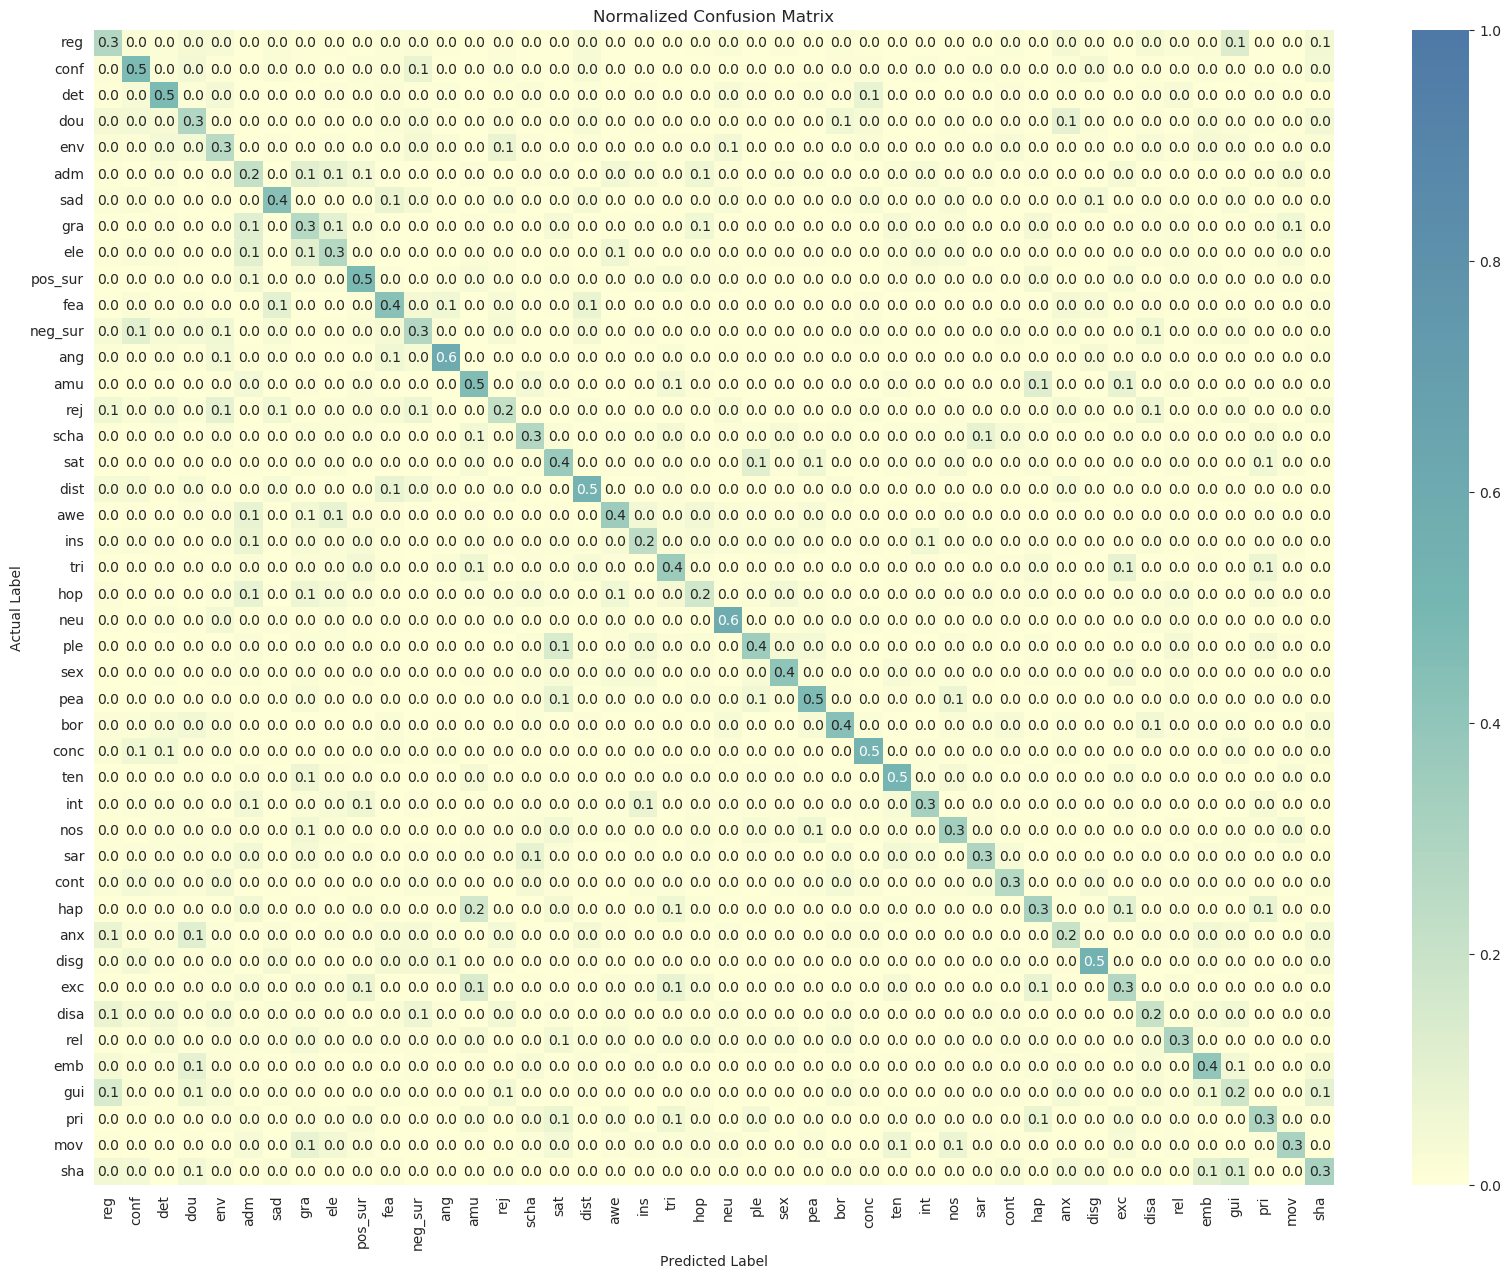

In [27]:
au_gaze_pose = transform_video_modality(slices_video, [*AU_INTENSITY_COLS, *GAZE_COLS, *POSE_COLS])

egemaps = df_audio[AUDIO_FUNCTIONALS_EGEMAPS_COLS].values
egemaps = functional_scale_by(egemaps, video_ids, "min_max")

all_modes = np.hstack((au_gaze_pose, egemaps))


clf = param_search(all_modes, y_audio_video)

eval = Evaluator(all_modes, y_audio_video, clf.best_params_, "all_modes")
eval.evaluate_scores("accuracy")
eval.evaluate_scores("roc_auc_ovo_weighted")
eval.evaluate_confusion_matrix()
eval.create_classification_report()

In [28]:
clf = param_search(egemaps, y_audio_video)

eval = Evaluator(egemaps, y_audio_video, clf.best_params_, "audio")
eval.evaluate_scores("accuracy")
eval.evaluate_scores("roc_auc_ovo_weighted")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  8.4min finished


{'C': 100, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


printing accuracy measures
avg (train): 0.7544142712588349
std (train): 0.002293300031004833
avg (validation): 0.11451988725559792
std (validation): 0.004875103344730454
printing roc_auc_ovo_weighted measures
avg (train): 0.9531413277521817
std (train): 0.0009002205439847527
avg (validation): 0.711987575949494
std (validation): 0.005057675275113844


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [13]:
au_gaze_pose = transform_video_modality(slices_video, [*AU_INTENSITY_COLS, *GAZE_COLS, *POSE_COLS])

clf = param_search(au_gaze_pose, y_audio_video)

eval = Evaluator(au_gaze_pose, y_audio_video, clf.best_params_, "au_gaze_pose")
eval.evaluate_scores("accuracy")
eval.evaluate_scores("roc_auc_ovo_weighted")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  7.1min finished


{'C': 25, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


printing accuracy measures
avg (train): 0.9994198384527465
std (train): 0.00010088590500042145
avg (validation): 0.3838155095303012
std (validation): 0.00836313857570934
printing roc_auc_ovo_weighted measures
avg (train): 0.9999943951185488
std (train): 2.0112666304587954e-06
avg (validation): 0.9107261195967038
std (validation): 0.0022989497368297663


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
